## 5.5 实践：基于ResNet18网络完成图像分类任务

在本实践中，我们实践一个更通用的图像分类任务。

**图像分类**（Image Classification）是计算机视觉中的一个基础任务，将图像的语义将不同图像划分到不同类别。很多任务也可以转换为图像分类任务。比如人脸检测就是判断一个区域内是否有人脸，可以看作一个二分类的图像分类任务。

这里，我们使用的计算机视觉领域的经典数据集：CIFAR-10数据集，网络为ResNet18模型，损失函数为交叉熵损失，优化器为Adam优化器，评价指标为准确率。

*******

Adam优化器的介绍参考《神经网络与深度学习》第7.2.4.3节。

*******

### 5.5.1 数据处理

#### 5.5.1.1 数据集介绍

CIFAR-10数据集包含了10种不同的类别、共60,000张图像，其中每个类别的图像都是6000张，图像大小均为$32\times32$像素。CIFAR-10数据集的示例如 **图5.15** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/12cb79a15a3d40fa9b0124dfe4681ab8b60b82d067fb433eb6da600b7c2ec875" width="600" hegiht="" ></center>
<center><br>图5.15：CIFAR-10数据集示例</br></center>
<br></br>

将数据集文件进行解压：

In [1]:
# 解压数据集
# 初次运行时将注释取消，以便解压文件
# 如果已经解压过，不需要运行此段代码，否则由于文件已经存在，解压时会报错
!tar -xvf /home/aistudio/data/data9154/cifar-10-python.tar.gz -C /home/aistudio/datasets/

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


#### 5.5.1.2 数据读取

在本实验中，将原始训练集拆分成了train_set、dev_set两个部分，分别包括40 000条和10 000条样本。将data_batch_1到data_batch_4作为训练集，data_batch_5作为验证集，test_batch作为测试集。
最终的数据集构成为：

* 训练集：40 000条样本。
* 验证集：10 000条样本。
* 测试集：10 000条样本。

读取一个batch数据的代码如下所示：

In [2]:
import os
import pickle
import numpy as np

def load_cifar10_batch(folder_path, batch_id=1, mode='train'):
    if mode == 'test':
        file_path = os.path.join(folder_path, 'test_batch')
    else:
        file_path = os.path.join(folder_path, 'data_batch_'+str(batch_id))

    #加载数据集文件
    with open(file_path, 'rb') as batch_file:
        batch = pickle.load(batch_file, encoding = 'latin1')

    imgs = batch['data'].reshape((len(batch['data']),3,32,32)) / 255.
    labels = batch['labels']

    return np.array(imgs, dtype='float32'), np.array(labels)

imgs_batch, labels_batch = load_cifar10_batch(folder_path='datasets/cifar-10-batches-py', 
                                                batch_id=1, mode='train')


查看数据的维度：

In [3]:
#打印一下每个batch中X和y的维度
print ("batch of imgs shape: ",imgs_batch.shape, "batch of labels shape: ", labels_batch.shape)

batch of imgs shape:  (10000, 3, 32, 32) batch of labels shape:  (10000,)


可视化观察其中的一张样本图像和对应的标签，代码如下所示：

The label in the picture is 9


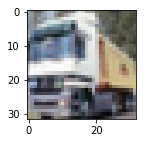

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

image, label = imgs_batch[1], labels_batch[1]
print("The label in the picture is {}".format(label))
plt.figure(figsize=(2, 2))
plt.imshow(image.transpose(1,2,0))
plt.savefig('cnn-car.pdf')

#### 5.5.1.3 构造Dataset类

构造一个CIFAR10Dataset类，其将继承自`paddle.io.DataSet`类，可以逐个数据进行处理。代码实现如下：

In [5]:
import paddle
import paddle.io as io
from paddle.vision.transforms import Normalize

class CIFAR10Dataset(io.Dataset):
    def __init__(self, folder_path='/home/aistudio/cifar-10-batches-py', mode='train'):
        if mode == 'train':
            #加载batch1-batch4作为训练集
            self.imgs, self.labels = load_cifar10_batch(folder_path=folder_path, batch_id=1, mode='train')
            for i in range(2, 5):
                imgs_batch, labels_batch = load_cifar10_batch(folder_path=folder_path, batch_id=i, mode='train')
                self.imgs, self.labels = np.concatenate([self.imgs, imgs_batch]), np.concatenate([self.labels, labels_batch])
        elif mode == 'dev':
            #加载batch5作为验证集
            self.imgs, self.labels = load_cifar10_batch(folder_path=folder_path, batch_id=5, mode='dev')
        elif mode == 'test':
            #加载测试集
            self.imgs, self.labels = load_cifar10_batch(folder_path=folder_path, mode='test')
        self.transform = Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010], data_format='CHW')

    def __getitem__(self, idx):
        img, label = self.imgs[idx], self.labels[idx]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)

paddle.seed(100)
train_dataset = CIFAR10Dataset(folder_path='/home/aistudio/datasets/cifar-10-batches-py', mode='train')
dev_dataset = CIFAR10Dataset(folder_path='/home/aistudio/datasets/cifar-10-batches-py', mode='dev')
test_dataset = CIFAR10Dataset(folder_path='/home/aistudio/datasets/cifar-10-batches-py', mode='test')

### 5.5.2 模型构建

使用飞桨高层API中的Resnet18进行图像分类实验。

In [6]:
from paddle.vision.models import resnet18

resnet18_model = resnet18()

W0503 13:12:10.322129   156 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0503 13:12:10.327652   156 device_context.cc:465] device: 0, cuDNN Version: 7.6.


******

飞桨高层 API是对飞桨API的进一步封装与升级，提供了更加简洁易用的API，进一步提升了飞桨的易学易用性。其中，飞桨高层API封装了以下模块：
1. Model类，支持仅用几行代码完成模型的训练；
1. 图像预处理模块，包含数十种数据处理函数，基本涵盖了常用的数据处理、数据增强方法；
1. 计算机视觉领域和自然语言处理领域的常用模型，包括但不限于mobilenet、resnet、yolov3、cyclegan、bert、transformer、seq2seq等等，同时发布了对应模型的预训练模型，可以直接使用这些模型或者在此基础上完成二次开发。
  
飞桨高层 API主要包含在`paddle.vision`和`paddle.text`目录中。

******

### 5.5.3 模型训练

复用RunnerV3类，实例化RunnerV3类，并传入训练配置。
使用训练集和验证集进行模型训练，共训练30个epoch。
在实验中，保存准确率最高的模型作为最佳模型。代码实现如下：

In [7]:
import paddle.nn.functional as F
import paddle.optimizer as opt
from nndl import RunnerV3, Accuracy

#指定运行设备
use_gpu = True if paddle.get_device().startswith("gpu") else False
if use_gpu:
    paddle.set_device('gpu:0')
#学习率大小
lr = 0.001  
#批次大小
batch_size = 64 
#加载数据
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = io.DataLoader(test_dataset, batch_size=batch_size) 
#定义网络
model = resnet18_model
#定义优化器，这里使用Adam优化器以及l2正则化策略，相关内容在7.3.3.2和7.6.2中会进行详细介绍
optimizer = opt.Adam(learning_rate=lr, parameters=model.parameters(), weight_decay=0.005)
#定义损失函数
loss_fn = F.cross_entropy
#定义评价指标
metric = Accuracy(is_logist=True)
#实例化RunnerV3
runner = RunnerV3(model, optimizer, loss_fn, metric)
#启动训练
log_steps = 3000
eval_steps = 3000
runner.train(train_loader, dev_loader, num_epochs=30, log_steps=log_steps, 
                eval_steps=eval_steps, save_path="best_model.pdparams")

                

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


[Train] epoch: 0/30, step: 0/18750, loss: 7.28671
[Evaluate]  dev_score: 0.05540, dev_loss: 12.52092
best accuracy performence has been updated: 0.00000 --> 0.05540
[Train] epoch: 4/30, step: 3000/18750, loss: 0.77707
[Evaluate]  dev_score: 0.65140, dev_loss: 1.01241
best accuracy performence has been updated: 0.05540 --> 0.65140
[Train] epoch: 9/30, step: 6000/18750, loss: 0.56135
[Evaluate]  dev_score: 0.72050, dev_loss: 0.83436
best accuracy performence has been updated: 0.65140 --> 0.72050
[Train] epoch: 14/30, step: 9000/18750, loss: 0.54198
[Evaluate]  dev_score: 0.70990, dev_loss: 0.88424
[Train] epoch: 19/30, step: 12000/18750, loss: 0.75522
[Evaluate]  dev_score: 0.71290, dev_loss: 0.89758
[Train] epoch: 24/30, step: 15000/18750, loss: 0.61934
[Evaluate]  dev_score: 0.72110, dev_loss: 0.83567
best accuracy performence has been updated: 0.72050 --> 0.72110
[Train] epoch: 28/30, step: 18000/18750, loss: 0.69278
[Evaluate]  dev_score: 0.72720, dev_loss: 0.82229
best accuracy perf

可视化观察训练集与验证集的准确率及损失变化情况。

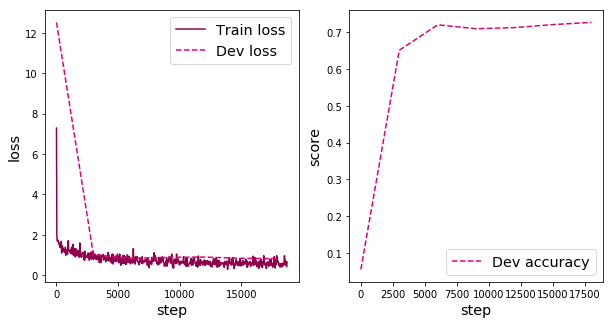

In [8]:
from nndl import plot

plot(runner, fig_name='cnn-loss4.pdf')

*******

在本实验中，使用了第7章中介绍的Adam优化器进行网络优化，如果使用SGD优化器，会造成过拟合的现象，在验证集上无法得到很好的收敛效果。可以尝试使用第7章中其他优化策略调整训练配置，达到更高的模型精度。

*******

### 5.5.4 模型评价

使用测试数据对在训练过程中保存的最佳模型进行评价，观察模型在测试集上的准确率以及损失情况。代码实现如下：

In [9]:
# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate(test_loader)
print("[Test] accuracy/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] accuracy/loss: 0.7234/0.8324


### 5.5.5 模型预测

同样地，也可以使用保存好的模型，对测试集中的数据进行模型预测，观察模型效果，具体代码实现如下：

The true category is 8 and the predicted category is 8


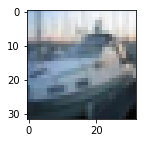

In [12]:
#获取测试集中的一个batch的数据
X, label = next(test_loader())
logits = runner.predict(X)
#多分类，使用softmax计算预测概率
pred = F.softmax(logits)
#获取概率最大的类别
pred_class = paddle.argmax(pred[2]).numpy()
label = label[2][0].numpy()
#输出真实类别与预测类别
print("The true category is {} and the predicted category is {}".format(label[0], pred_class[0]))
#可视化图片
plt.figure(figsize=(2, 2))
imgs, labels = load_cifar10_batch(folder_path='/home/aistudio/datasets/cifar-10-batches-py', mode='test')
plt.imshow(imgs[2].transpose(1,2,0))
plt.savefig('cnn-test-vis.pdf')

## 5.6 实验拓展

* 尝试加深残差网络的层数或使用《神经网络与深度学习》中介绍的其他模型完成基于CIFAR10的图像分类实验，观察是否能够得到更高的精度；
* 尝试使用CIFAR-100进行实验，观察不同模型在不同数据集上的学习效果；